## Part 1
#### To-do
* Note that `predict` method should take as input a tensor with values in 0-255 and should output a tensor with values in 0-255
* Test with RED30 model

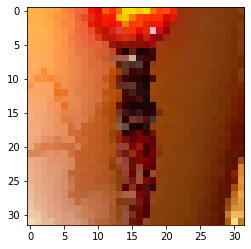

In [5]:
import torch
import matplotlib.pyplot as plt

torch.set_grad_enabled(True)

train_dir = "train_data.pkl"
val_dir = "val_data.pkl"
noisy_imgs_1 , noisy_imgs_2 = torch.load("train_data.pkl")
noisy_imgs , clean_imgs = torch.load("val_data.pkl")

plt.imshow((noisy_imgs_1[1].float()/255.0).permute(1, 2, 0))

In [10]:
from train import *
from unet import *
import torch.nn as nn
import torch.optim as optim

model = Unet(3, 3)
optim = optim.Adam(model.parameters(), lr=10e-4)
loss_fn = nn.MSELoss()

model_outputs = train_model(load_model=False, save_model=False, 
                            model=model, optimizer=optim, loss_fn=loss_fn, 
                            batch_size=100, num_epochs=2)


[PSNR : 23.11 dB], PSNR before training = 20.72 dB


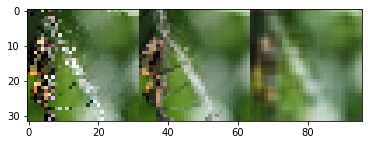

In [11]:
from utils import *

i = 10
plot_prediction_clean(noisy_imgs[i].float()/255.0, clean_imgs[i].float()/255.0, model_outputs[i])

## Part 2
* Implementation of Conv2d : https://coolgpu.github.io/coolgpu_blog/github/pages/2020/10/04/convolution.html and https://github.com/coolgpu/Demo_Conv2d_forward_and_backward/blob/master/my_conv2d_v1.py
* Implementation of transposed convolution (if needed) : https://coolgpu.github.io/coolgpu_blog/github/pages/2021/02/18/transposed_convolution.html
* Chain rule gradients and stuff : https://coolgpu.github.io/coolgpu_blog/github/pages/2020/09/14/backpropagation.html#_Derivation_of_the_gradients
#### To-do
* Weight initialization function (for example xavier init) ? see https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
* Refine modules so that their arguments match exactly their pytorch counterparts

In [ ]:
import torch
torch.set_grad_enabled(False)

In [ ]:
import torch.nn as nn

## Test the requested netwok using PyTorch to be able to compare with our implementation
class SimpleNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(SimpleNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, out_ch, 3, padding=1),
            nn.Sigmoid(inplace=True)
        )

    def forward(self, x):
        return self.seq(x)

In [ ]:
from torch import empty, cat, arange
from torch.nn.functional import fold, unfold

class Conv2d(object):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        self.id = 'Conv2d'
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = torch.zeros((out_channels, in_channels, kernel_size, kernel_size), dtype=torch.float) #change to torch.empty
        self.bias = None
        if bias:
            self.bias = torch.zeros((out_channels), dtype=torch.float)
    
    def forward(self, input_t):
        assert input_t.ndim == 4 and input_t.shape[1] == self.in_channels, f"input tensor should be of shape (nImages, {self.in_channels}, Y, X)"
        self.in_size_y = input_t.shape[2]
        self.in_size_x = input_t.shape[3]
        
        #General formula for computing the output sizes of images depending on the input size, the kernel size, the padding and the stride.
        self.out_size_y = ((self.in_size_y + 2*self.padding - self.kernel_size) // self.stride) + 1
        self.out_size_x = ((self.in_size_x + 2*self.padding - self.kernel_size) // self.stride) + 1
        
        #Here we use unfold to facilitate the sliding window operations of our convolution
        # unfold takes an input a tensor of shape (N, C, Y, X) where N is the number of 2D images, C is the number of channels per image, 
        # Y, X is the dimension of each 2D image. Unfold also takes as input the kernel size K (in our convolution we assume the kernel to always be a square, thus number of elements in kernel is K*K).
        # For each image, unfold extracts patches of same size as the kernel size, for each channel.
        # Each patch can be seen a 1D vertical vector (instead of a 2D matrix), and patches of the same channel are concatenated so as to obtain, for one channel, a 2D matrix of shape (K*K, out_size_y*out_size_x). Patches are concatenated in order from left to right and from top to bottom.
        # Then matrices of each channel are concatenated vertically so as to obtain a 2D matrix of shape (C*K*K, out_size_y*out_size_x). Matrices are concatenated in order of channels.
        # out_size_y represents the Y axis of output image, out_size_x represents the X axis of output image.
        # Since this procedure is done for each image, the resulting tensor of unfold is of shape (N, C*K*K, out_size_y*out_size_x).
        patch_tensor = torch.nn.functional.unfold(input_t, (self.kernel_size, self.kernel_size), padding=self.padding, stride=self.stride)
        
        #Useful for backward pass
        self.input_unfolded = patch_tensor
        
        # Transpose the patches tensor so as to obtain, for each image, the C patches of same location in a row instead of in a column.
        patch_tensor = patch_tensor.transpose(1, 2)
        
        #Reshape the kernel so as to match the shape of patches in patches tensor. Note that each row in the patches tensor is of size C*K*K,
        # and each row in the reshaped kernel is also of size (C*K*K).
        kernel_w = self.weights.view(self.out_channels, -1)
        
        #For matrix multiplication (apply the kernel on the patches) of the patches tensor with the reshaped kernel, we transpose the reshaped kernel so as to have C*K*K rows.
        kernel_w = kernel_w.t()
        
        #Matrix multiplication, i.e. apply kernel on patches
        #Resulting conv has shape (N, out_size_y*out_size_x, out_channels)
        conv = patch_tensor @ kernel_w
        
        #Transpose and reshape to match the input tensor shape (batch of images), get shape (N, out_channels, out_size_y, out_size_x)
        output_t = conv.transpose(1, 2).reshape(input_t.shape[0], self.out_channels, out_size_y, out_size_x)
        
        #Add bias if needed
        if self.bias is not None:
            output_t += self.bias.view(1, self.out_channels, 1, 1)
        
        return output_t
        
    def backward(self, grad_output):
        assert (grad_output.ndim == 4 and grad_output.shape[1] == self.out_channels 
        and grad_output.shape[2] == self.out_size_y and grad_output.shape[3] == self.out_size_x), 
        f"input tensor should be of shape (nImages, {self.out_channels}, {self.out_size_y}, {self.out_size_x})"
        
        #Reshape into (N, out_channels, out_size_y*out_size_x)
        grad_out_reshaped = grad_output.reshape(grad_output.shape[0], self.out_channels, -1)
        
        #Transpose to pass channels in last dimension to get (N, out_size_y*out_size_x, out_channels)
        grad_out_reshaped = grad_out_reshaped.transpose(1, 2)
        
        #Compute gradient of loss wrt input using the kernel weights. Resulting shape (N, out_size_y*out_size_x, C*K*K).
        #C = A@B => d_l/d_A = d_l/d_C @ B.t, out = in@weights => d_l/d_in = d_l/d_out @ weights
        grad_input_unfolded = grad_out_reshaped @ self.weights.view(self.out_channels, -1)
        
        #Reshape gradient of loss wrt input by "unpatching" the images to obtain a (N, C, in_size_y, in_size_x) tensor
        grad_input = torch.nn.functional.fold(grad_input_unfolded.transpose(1, 2), (self.in_size_y, self.in_size_x), (self.kernel_size, self.kernel_size), padding=self.padding, stride=self.stride)
        assert grad_input.shape == (grad_output.shape[0], self.in_channels, self.in_size_y, self.in_size_x)
        
        #Compute gradient of loss wrt weight kernel. Resulting shape (N, C*K*K, out_channels)
        #C = A@B => d_l/d_B = A.t @ d_l/d_C, since out=in@w (unfolded), d_l/d_w = in.t @ d_l/d_out
        grad_weights = self.input_unfolded @ grad_out_reshaped
        
        #Sum over the batch of N images (sum over the gradients of images). Resulting shape (C*K*K, out_channels)
        self.grad_weights = grad_weights.sum(dim=0)
        
        #Reshape to obtain original weights shape (out_channels, in_channels (C), K, K)
        self.grad_weights = self.grad_weights.t().view(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        
        self.grad_bias = None
        if self.bias is not None:
            #For each image, sum over full image to obtain 1 bias value for each "out_channel" channel.
            #Sum over the batch of N images (sum over the gradients of images). Resulting shape (out_channels).
            self.grad_bias = grad_output.sum(dim=[0, 2, 3])
        return grad_input
        
    def parameters(self):
        return [(self.weights, self.grad_weights), (self.bias, self.grad_bias)]

In [ ]:
class Upsample(object):
    
    def __init__(self, scale_factor=1):
        self.id = 'Upsample'
        self.scale_factor = scale_factor
    
    def forward(self, input_t):
        
        
    def backward(self, grad_output):
        raise NotImplementedError
        
    def parameters(self):
        return []

In [ ]:
class Sigmoid(object):
    
    def __init__(self):
        self.id = 'Sigmoid'
        
    def forward(self, input_t):
        self.sig = input_t.sigmoid()
        return self.sig
        
    #grad_output is d_l/d_x and we want to compute d_l/d_s
    def backward(self, grad_output):
        #sig*(1-sig)
        grad_sig = self.sig.mul(1-self.sig)
        return grad_output.mul(grad_sig)
        
    def parameters(self):
        return []

In [ ]:
class ReLU(object):
    
    def __init__(self):
        self.id = 'ReLU'

    def forward(self, input_t):
        #max(0, x)
        self.relu = input_t.maximum(0)
        return self.relu
        
        
    def backward(self, grad_output):
        #sign(max(0, x))
        grad_relu = self.relu.gt(0).int().float()
        return grad_output.mul(grad_relu)
        
    def parameters(self):
        return []

In [ ]:
class Sequential(object):
    def __init__(self, *modules):
        self.id = 'Sequential'
        self.modules = [m for m in modules]
        
    def modules():
        return self.modules
    
    def forward(self, input_t):
        x = input_t.clone()
        for module in self.modules:
            x = module.forward(x)
        return x
        
    def backward(self, grad_output):
        x = grad_output.clone()
        for module in self.modules:
            x = module.backward(x)
        return x
        
    def parameters(self):
        params = []
        for module in self.modules:
            if module.id == 'Sequential':
                for seq_module in module.parameters():
                    params.append(seq_module.parameters())
            elif module.parameters():
                params.append(module.parameters())
        return params

In [ ]:
class MSELoss(object):
    
    def __init__(self):
        pass
    
    def forward(self, pred, target):
        assert pred.shape == target.shape and pred.ndim == 4, "shapes need 4 dimensions and should match"
        self.pred = pred
        self.target = target
        return (pred - target).square().sum(dim=0).div(pred.shape[0])
        
    def backward(self):
        return 2*(self.pred - self.target)
        
    def parameters(self):
        return []

In [ ]:
class CustomNN(object):
    def __init__(self, in_ch, out_ch):
        self.seq = Sequential(
            Conv2d(in_ch, 64, 3, stride=2, padding=1),
            ReLU(),
            Conv2d(64, 128, 3, stride=2, padding=1),
            ReLU(),
            Upsample(scale_factor=2),
            Conv2d(128, 64, 3, padding=1),
            ReLU(),
            Upsample(scale_factor=2),
            Conv2d(64, out_ch, 3, padding=1),
            Sigmoid()
        )
        
    def forward(self, x):
        return self.seq.forward(x)
    
    def backward(self, grad_loss):
        return self.seq.backward(grad_loss)
    
    def parameters(self):
        return self.seq.parameters()

In [ ]:
class SGD(object):
    def __init__(self, model_params, lr=0.001):
        self.model_params = model_params
        self.lr = lr
        
    def step(self):
        for i in range(len(self.model_params)):
            for j in range(len(self.model_params[i])):
                if self.model_params[i, j][0] is not None and self.model_params[i, j][1] is not None:
                    self.model_params[i, j][0] -= lr*self.model_params[i, j][1]

In [ ]:
model = CustomNN()
loss_fn = MSELoss()
optimizer = SGD(model.parameters(), lr=0.001)

loop = tqdm(loader)

for data, targets in loop:

    # forward
    predictions = model.forward(data)
    loss = loss_fn.forward(predictions, targets)

    # backward
    #optimizer.zero_grad()
    model.backward(loss_fn.backward())
    optimizer.step()

    loop.set_postfix(loss=loss.item())

In [21]:
import torch
from torch.nn.functional import fold, unfold

unfold = torch.nn.Unfold((3, 3), padding=0, stride=1)
a = torch.tensor([
            [[[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [3, 3, 3, 3, 3], [4, 4, 4, 4, 4], [5, 5, 5, 5, 5]], [[6, 6, 6, 6, 6], [7, 7, 7, 7, 7], [8, 8, 8, 8, 8], [9, 9, 9, 9, 9], [10, 10, 10, 10, 10]], [[11, 11, 11, 11, 11], [12, 12, 12, 12, 12], [13, 13, 13, 13, 13], [14, 14, 14, 14, 14], [15, 15, 15, 15, 15]]], 
             [[[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [3, 3, 3, 3, 3], [4, 4, 4, 4, 4], [5, 5, 5, 5, 5]], [[6, 6, 6, 6, 6], [7, 7, 7, 7, 7], [8, 8, 8, 8, 8], [9, 9, 9, 9, 9], [10, 10, 10, 10, 10]], [[11, 11, 11, 11, 11], [12, 12, 12, 12, 12], [13, 13, 13, 13, 13], [14, 14, 14, 14, 14], [15, 15, 15, 15, 15]]]
             ], dtype=torch.float)

u1 = unfold(a)
print(u1)
print(torch.nn.functional.fold(u1, (5, 5), (3, 3), padding=0, stride=1))
#print(a.sum(dim=[0, 2, 3]))

tensor([[[ 1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.],
         [ 1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.],
         [ 1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.],
         [ 2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.],
         [ 2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.],
         [ 2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.],
         [ 3.,  3.,  3.,  4.,  4.,  4.,  5.,  5.,  5.],
         [ 3.,  3.,  3.,  4.,  4.,  4.,  5.,  5.,  5.],
         [ 3.,  3.,  3.,  4.,  4.,  4.,  5.,  5.,  5.],
         [ 6.,  6.,  6.,  7.,  7.,  7.,  8.,  8.,  8.],
         [ 6.,  6.,  6.,  7.,  7.,  7.,  8.,  8.,  8.],
         [ 6.,  6.,  6.,  7.,  7.,  7.,  8.,  8.,  8.],
         [ 7.,  7.,  7.,  8.,  8.,  8.,  9.,  9.,  9.],
         [ 7.,  7.,  7.,  8.,  8.,  8.,  9.,  9.,  9.],
         [ 7.,  7.,  7.,  8.,  8.,  8.,  9.,  9.,  9.],
         [ 8.,  8.,  8.,  9.,  9.,  9., 10., 10., 10.],
         [ 8.,  8.,  8.,  9.,  9.,  9., 10., 10., 10.],
         [ 8.,  8.,  8.,  9.,  9.,  9., 10., 10.

In [1]:
import torch

a = torch.tensor([[[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]]])
print(a)

ModuleNotFoundError: No module named 'torch'